#Classification

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= '0.20'

import numpy as np
import pandas as pd
import os

np.random.seed(42)

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Fig save path
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id+'.'+fig_extension)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution) 

#Explore mnist data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

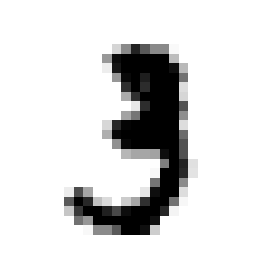

In [35]:
#Sample digit

def plot_digit(num):
  
  num_img = num.reshape(28, 28)
  plt.imshow(num_img, cmap=mpl.cm.binary)
  plt.axis('off')

num = X[10]
plot_digit(num)
save_fig('sample_digit')
plt.show()

In [5]:
y[10]

'3'

In [6]:
def plot_digit(data):
  image = data.reshape(28, 28)
  plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
  plt.axis('off')

In [7]:
def plot_digits(instances, images_per_row=10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size, size) for instance in instances]
  n_row = (len(instances) - 1)//(images_per_row) + 1
  row_images=[]
  n_empty = n_row * images_per_row - len(instances)
  images.append(np.zeros((size, size*n_empty)))
  for row in range(n_row):
    rimages = images[row * images_per_row : (row+1) * images_per_row]
    row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap=mpl.cm.binary, **options)
  plt.axis('off')

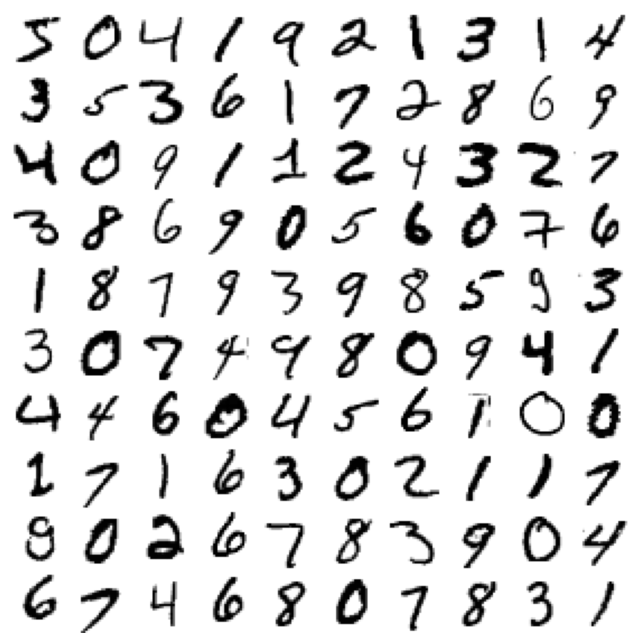

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [9]:
#Test and train data split
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
#Binary Clf

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([X_train[0]])

array([ True])

In [13]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

#Stratified validation split and cross validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  #clone the clf and train again (trains from scratch, no partial_fit here)
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [15]:
#Cross val score

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [16]:
#Never 5 Classifier
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

#Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_pred)

array([[53892,   687],
       [ 1891,  3530]])

#Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_pred)

0.6511713705958311

In [20]:
f1_score(y_train_5, y_pred)

#F1 score favors clf that have similar precision and recall
#If either is low, F1 score will be low, this is why harmonic mean is used in F1 score


0.7325171197343846

#Classification Threshold
#Precision/Recall tradeoff

[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]


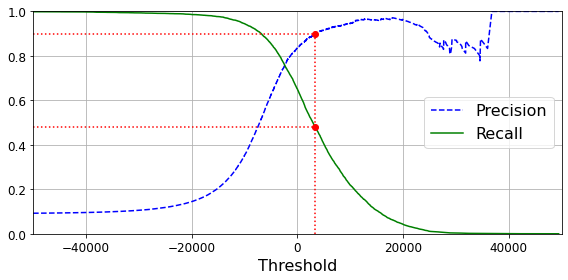

In [21]:
#Get decision scores instead of predictions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')

#Get precision and recall for all thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print(precisions)
#plot Precision-Recall curve

def plot_precision_recall_threshold(precisions, recalls, thresholds):
  #Last point is where precision=1 and recall=0, does not exist in thresholds, so removed from precisions and recall
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  plt.legend(loc='center right', fontsize=16)
  plt.xlabel('Threshold', fontsize=16)
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_threshold(precisions, recalls, thresholds)

#Plot the vertical and horizontal lines
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")      

#Plot the dots
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

save_fig('precisions_recall_vs_threshold')
plt.show()

#Precision vs Recall

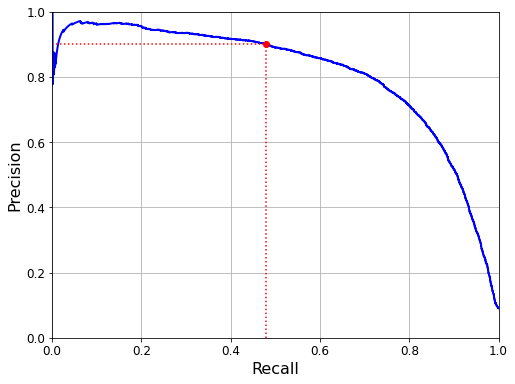

<Figure size 432x288 with 0 Axes>

In [22]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, 'b-', linewidth=2)
  plt.xlabel('Recall', fontsize=16)
  plt.ylabel('Precision', fontsize=16)
  plt.axis([0, 1, 0, 1])
  plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], 'ro')
plt.show()
save_fig('precision_vs_recall')

#ROC Curve

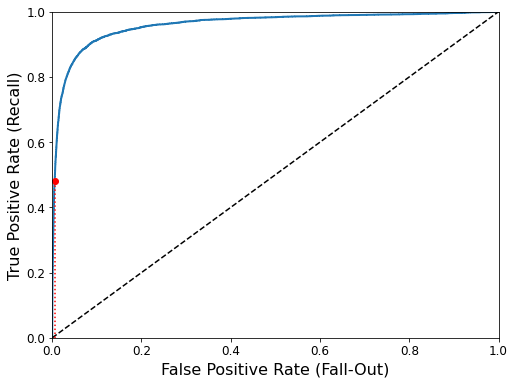

<Figure size 432x288 with 0 Axes>

In [23]:
#Recall (TPR) vs FPR (1-TNR; 1-specificity)
#sentivity vs 1-specificity

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') #Dashed diagonal
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")    

plt.show()
save_fig('roc_curve')

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

#Instead of decision score RF gives probabilities

y_probas_rf = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                method='predict_proba')

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_probas_rf[:, 1])

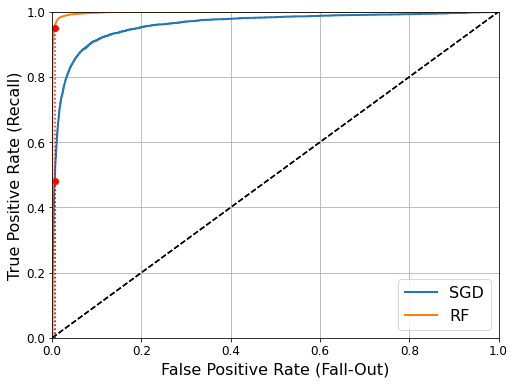

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label='SGD')
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")    

recall_rf = tpr_rf[np.argmax(fpr_rf >= fpr_90)]

plot_roc_curve(fpr_rf, tpr_rf, label='RF')

plt.plot([fpr_90, fpr_90], [0., recall_rf], "r:")
plt.plot([0.0, fpr_90], [recall_rf, recall_rf], "r:")
plt.plot([fpr_90], [recall_rf], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)    

plt.show()
save_fig('roc_curve_comparison')

In [27]:
roc_auc_score(y_train_5, y_probas_rf[:, 1])

0.9983436731328145

### MultiClass Classification

In [32]:
#Sklearn detects when binary classifier is used for Multiclass and runs OvR or OvO depending on the algo

#SVC is a binary classifier

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([X_train[5]])

array([2], dtype=uint8)

In [34]:
pred_scores = svm_clf.decision_function([X_train[5]])
pred_scores

array([[ 4.90014896, -0.28867999,  9.30019131,  2.78538604,  0.74732387,
         7.19334195,  1.80196388,  4.88234364,  5.11280012,  8.24768654]])

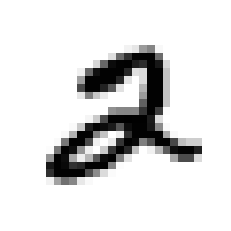

In [36]:
num = X_train[5]
plot_digit(num)

In [37]:
np.argmax(pred_scores)

2

In [39]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [72]:
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [75]:
svm_clf.decision_function_shape

'ovr'

In [77]:
pred_scores = svm_clf.decision_function([X_train[5]])
pred_scores

array([[ 4.90014896, -0.28867999,  9.30019131,  2.78538604,  0.74732387,
         7.19334195,  1.80196388,  4.88234364,  5.11280012,  8.24768654]])

In [50]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())

ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC())

In [52]:
ovr_clf.get_params()

{'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None}

In [66]:
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

In [65]:
pred_scores = ovr_clf.decision_function([X_train[5]])
pred_scores

array([[-1.14804687, -2.00085858,  0.83282728, -1.5833969 , -1.91405337,
        -1.09948336, -1.19731952, -1.24355565, -1.28000792, -0.99997322]])

In [67]:
#OVO

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SVC())

ovo_clf.fit(X_train[:1000], y_train[:1000])

OneVsOneClassifier(estimator=SVC())

In [68]:
ovo_clf.get_params()

{'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None}

In [70]:
len(ovo_clf.estimators_)

45

In [76]:
pred_scores = ovo_clf.decision_function([X_train[5]])
pred_scores

array([[ 4.90320868, -0.2875004 ,  9.30015307,  2.7829964 ,  0.7488084 ,
         7.19331218,  1.80150184,  4.87161921,  5.1151701 ,  8.24442883]])

In [79]:
#SGD Clf with Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [82]:
#Error analysis

y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train[:20000], y_train_pred[:20000])
conf_mx

array([[1877,    0,   14,    2,    2,   17,   11,    1,   70,    0],
       [   0, 2144,   16,    6,    1,   16,    2,    0,   91,    5],
       [   9,   10, 1669,   37,   29,    7,   27,    8,  132,    1],
       [   5,    8,   41, 1790,    1,   62,    8,   20,  114,   27],
       [   3,    4,   16,    3, 1740,    8,   13,    7,   91,   60],
       [   9,    6,    9,   61,   17, 1483,   26,    3,  140,   21],
       [  15,    3,    9,    2,   11,   27, 1856,    3,   45,    0],
       [   6,    0,   21,   12,   24,    3,    1, 1888,   56,   82],
       [   7,   17,   20,   32,    1,   36,   13,    4, 1774,   18],
       [   9,    6,   14,   21,   35,   15,    1,   47,  120, 1746]])

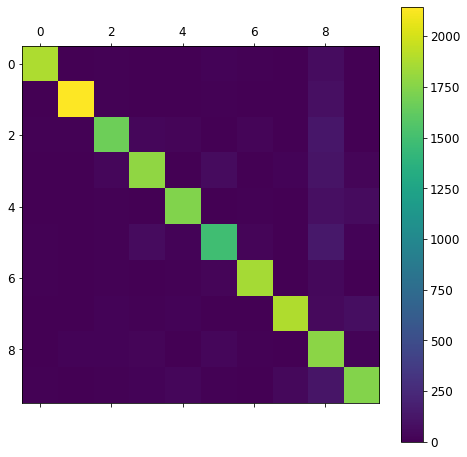

In [86]:
def plot_confusion_matrix(matrix):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plot_confusion_matrix(conf_mx)

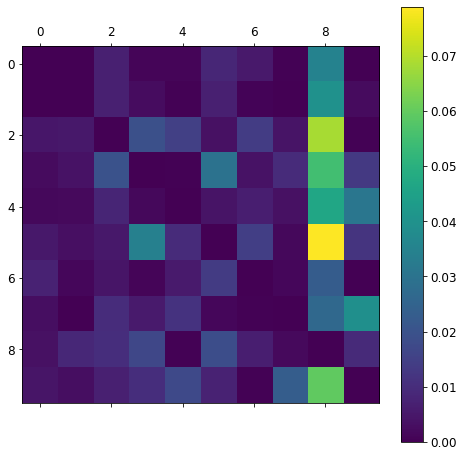

In [87]:
#Normalize the conf matrix and show the errors

norm_conf_mx = conf_mx/(conf_mx.sum(axis=1, keepdims=True))
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

#Multilabel Classification

In [91]:
X_train = X_train[:20000]
y_train = y_train[:20000]

In [92]:
from sklearn.neighbors import KNeighborsClassifier

#Clf to predict if a number is =<3 and odd

y_train_small = (y_train<=3)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_small, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [98]:
knn_clf.predict([X[6]])

array([[ True,  True]])

In [99]:
y[6]

1

In [100]:
y_train_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_pred, average='weighted')

0.9719694401464318

#Multi Output Classification

In [102]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
y_train_mod = X_train

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_test_mod = X_test

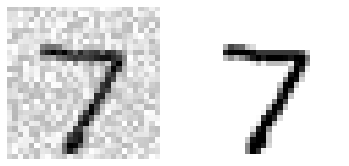

In [105]:
id = 0

plt.subplot(121)
plot_digit(X_test_mod[id])

plt.subplot(122)
plot_digit(y_test_mod[id])

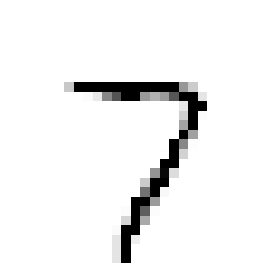

In [106]:
knn_clf.fit(X_train_mod, y_train_mod)
clean = knn_clf.predict([X_test_mod[id]])
plot_digit(clean)
save_fig('clean_digit')